# Prediction credit card fulfilling payment

# Data Check

In [70]:
# data read
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score           # 0.21.2
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier

df_train = pd.read_csv('train_data.csv')
df_test = pd.read_csv('test_data.csv')

In [71]:
df_train

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
0,0,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,1,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,2,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,3,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
4,4,50000,1,1,2,37,0,0,0,0,...,19394,19619,20024,2500,1815,657,1000,1000,800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,26995,100000,1,1,2,38,0,-1,-1,0,...,70626,69473,55004,2000,111784,4000,3000,2000,2000,0
26996,26996,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
26997,26997,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
26998,26998,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [72]:
df_test_raw = df_test.copy()
df_test

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
1,1,630000,2,2,2,41,-1,0,-1,-1,...,6500,6500,6500,2870,1000,6500,6500,6500,2870,0
2,2,320000,1,1,1,49,0,0,0,-1,...,194663,70074,5856,195599,10358,10000,75940,20000,195599,50000
3,3,120000,2,2,1,39,-1,-1,-1,-1,...,316,0,632,316,316,316,0,632,316,0
4,4,50000,2,3,2,30,0,0,0,0,...,17163,17878,18931,19617,1300,1300,1000,1500,1000,1012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2995,500000,1,2,2,31,0,0,-1,0,...,294257,278725,89161,87863,6025,294318,10254,7524,5009,2333
2996,2996,50000,1,2,2,30,1,-1,2,-1,...,264,7300,0,0,528,0,7300,0,0,0
2997,2997,250000,1,1,1,34,0,0,0,0,...,243075,245750,175005,179687,65000,8800,9011,6000,7000,6009
2998,2998,80000,1,2,2,34,2,2,2,2,...,79384,77519,82607,81158,7000,3500,0,7000,0,4000


In [73]:
# Check null
df_train.isnull().sum()

id     0
X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
y      0
dtype: int64

In [74]:
# X6 ~ X11 means 'Cash Flow': late to payment
# X12 ~ X17 means 'Buy'
# X8 ~ X23 means 'Payment'
df_train.describe()

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
count,27000.00000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000,...,27000.000000,27000.000000,27000.000000,27000.000000,2.700000e+04,27000.000000,27000.000000,27000.000000,27000.000000,27000.000000
mean,13499.50000,166856.284444,1.603074,1.853741,1.551556,35.502407,-0.012519,-0.128185,-0.162370,-0.216037,...,43247.852074,40345.600926,38894.870926,5644.593222,5.934313e+03,5229.052593,4855.124630,4782.051667,5238.613148,0.222000
std,7794.37297,129363.239705,0.489269,0.789234,0.521767,9.221539,1.121953,1.196953,1.195634,1.169587,...,64150.721252,60681.919736,59547.938323,16499.811285,2.360826e+04,17745.539585,15826.973077,15154.386855,17865.467132,0.415599
min,0.00000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6749.75000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2392.750000,1798.500000,1287.000000,1000.000000,8.500000e+02,396.000000,300.000000,272.000000,140.000000,0.000000
50%,13499.50000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19114.000000,18219.500000,17179.000000,2100.000000,2.009000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,20249.25000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54537.750000,50211.000000,49243.500000,5007.000000,5.000000e+03,4500.000000,4014.250000,4069.000000,4002.250000,0.000000
max,26999.00000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


# Find effected factor

XGB 0.8127037037037036


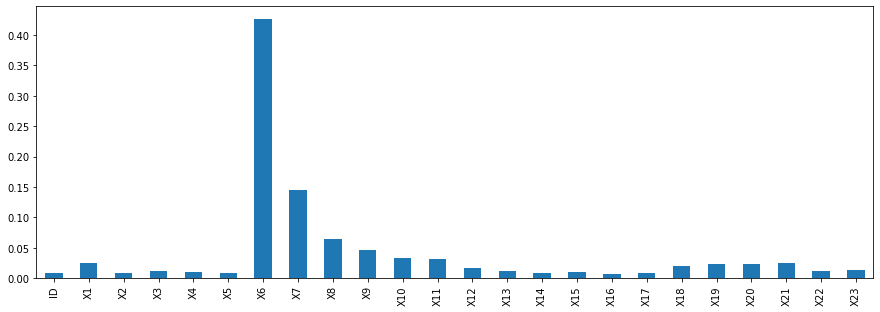

In [75]:
train_y = df_train["y"]
train_x = df_train.drop("y", axis=1)
train_x = train_x.rename(columns={'id': 'ID'})

xgb_model = XGBClassifier()
print('XGB', cross_val_score(xgb_model, train_x, train_y, cv=10).mean())

xgb_model.fit(train_x, train_y)
fimp_df = pd.DataFrame({"fimp": xgb_model.feature_importances_}, index=train_x.columns)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
fimp_df.plot(ax=ax1, legend=False, kind='bar')
plt.show()

# Preprocessing 1st

In [76]:
a1s = []
a2s = []
a3s = []
b1s = []
b2s = []
b3s = []
for indx in tqdm(train_x.index):
    x = [1, 2, 3, 4, 5, 6]

    # y1:payment record, y2:bill, y3:payment in advance
    y1 = train_x.loc[indx, "X6":"X11"]
    y2 = train_x.loc[indx, "X12":"X17"]
    y3 = train_x.loc[indx, "X18":"X23"]

    # Fitting function(a:trend, b:intercept)
    a1, b1 = np.polyfit(x, y1, 1)
    a2, b2 = np.polyfit(x, y2, 1)
    a3, b3 = np.polyfit(x, y3, 1)

    a1s.append(a1); a2s.append(a2); a3s.append(a3)
    b1s.append(b1); b2s.append(b2); b3s.append(b3)

train_x["a1"] = a1s
train_x["a2"] = a2s
train_x["a3"] = a3s
train_x["b1"] = b1s
train_x["b2"] = b2s
train_x["b3"] = b3s

a1s = []; a2s = []; a3s = []; b1s = []; b2s = []; b3s = []
for indx in tqdm(df_test.index):
    x = [1, 2, 3, 4, 5, 6]
    y1 = df_train.loc[indx, "X6":"X11"]
    y2 = df_train.loc[indx, "X12":"X17"]
    y3 = df_train.loc[indx, "X18":"X23"]

    a1, b1 = np.polyfit(x, y1, 1)
    a2, b2 = np.polyfit(x, y2, 1)
    a3, b3 = np.polyfit(x, y3, 1)

    a1s.append(a1)
    a2s.append(a2)
    a3s.append(a3)
    b1s.append(b1)
    b2s.append(b2)
    b3s.append(b3)

df_test["a1"] = a1s
df_test["a2"] = a2s
df_test["a3"] = a3s
df_test["b1"] = b1s
df_test["b2"] = b2s
df_test["b3"] = b3s

train_x

100%|██████████| 3000/3000 [00:07<00:00, 378.26it/s]


,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X20,X21,X22,X23,a1,a2,a3,b1,b2,b3
0,0,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,-0.914286,-844.571429,-59.057143,2.866667,4240.000000,321.533333
1,1,120000,2,2,2,26,-1,2,0,0,...,1000,1000,0,2000,0.257143,247.857143,200.000000,-0.400000,1978.666667,133.333333
2,2,90000,2,2,2,34,0,0,0,0,...,1000,1000,1000,5000,0.000000,-1854.714286,454.571429,0.000000,23433.666667,245.333333
3,3,50000,1,2,1,57,-1,0,-1,0,...,10000,9000,689,679,0.171429,2231.514286,-3302.314286,-0.933333,10412.866667,21399.600000
4,4,50000,1,1,2,37,0,0,0,0,...,657,1000,1000,800,0.000000,-10641.257143,-302.914286,0.000000,76930.066667,2355.533333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,26995,100000,1,1,2,38,0,-1,-1,0,...,4000,3000,2000,2000,0.114286,12330.800000,-9438.628571,-0.733333,7270.200000,53832.533333
26996,26996,150000,1,3,2,43,-1,-1,-1,-1,...,8998,129,0,0,0.228571,204.228571,-818.057143,-1.466667,2815.533333,5278.200000
26997,26997,30000,1,2,2,37,4,3,2,-1,...,22000,4200,2000,3100,-0.914286,4250.228571,105.714286,4.533333,-3126.466667,4846.666667
26998,26998,80000,1,3,1,41,1,-1,0,0,...,1178,1926,52964,1804,-0.200000,852.657143,-7744.771429,0.533333,41450.866667,51636.866667


XGB 0.8121481481481482


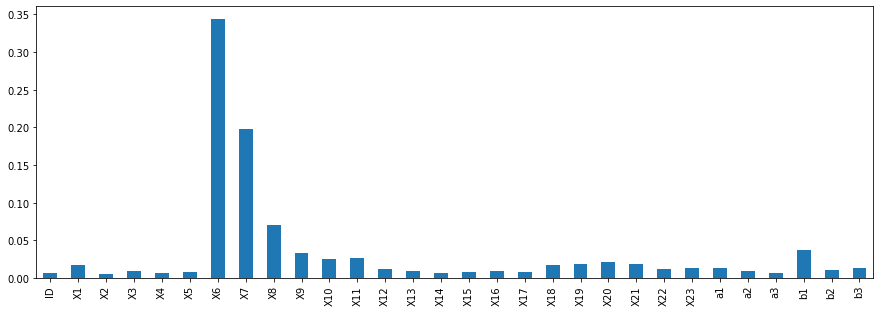

In [77]:
xgb_model = XGBClassifier()
print('XGB', cross_val_score(xgb_model, train_x, train_y, cv=10).mean())

xgb_model.fit(train_x, train_y)
fimp_df = pd.DataFrame({"fimp": xgb_model.feature_importances_}, index=train_x.columns)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
fimp_df.plot(ax=ax1, legend=False, kind='bar')
plt.show()

# Preprocessing 2nd

In [78]:
# Add elements high effection
train_x["X1/X6"] = train_x["X1"] / train_x["X6"]
train_x["X6/X7"] = train_x["X6"] / train_x["X7"]
train_x["X12/X13"] = train_x["X12"] / train_x["X13"]
train_x["X1/X12"] = train_x["X1"] / train_x["X12"]
train_x["X6/X12"] = train_x["X6"] / train_x["X12"]

df_test["X1/X6"] = df_test["X1"] / df_test["X6"]
df_test["X6/X7"] = df_test["X6"] / df_test["X7"]
df_test["X12/X13"] = df_test["X12"] / df_test["X13"]
df_test["X1/X12"] = df_test["X1"] / df_test["X12"]
df_test["X6/X12"] = df_test["X6"] / df_test["X12"]

# maybe means -2 & -1 same.
for col in ["X6", "X7", "X8", "X9", "X10", "X11"]:
    train_x[col] = [-1 if val == -2 else val for val in train_x[col]]
    df_test[col] = [-1 if val == -2 else val for val in df_test[col]]

train_x["X6/X7"] = train_x["X6/X7"].fillna(0)
train_x["X12/X13"] = train_x["X12/X13"].fillna(0)
train_x["X6/X12"] = train_x["X6/X12"].fillna(0)
df_test["X6/X7"] = df_test["X6/X7"].fillna(0)
df_test["X12/X13"] = df_test["X12/X13"].fillna(0)
df_test["X6/X12"] = df_test["X6/X12"].fillna(0)

train_x

,ID,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,a2,a3,b1,b2,b3,X1/X6,X6/X7,X12/X13,X1/X12,X6/X12
0,0,20000,2,2,1,24,2,2,-1,-1,...,-844.571429,-59.057143,2.866667,4240.000000,321.533333,10000.0,1.000000,1.261444,5.111168,0.000511
1,1,120000,2,2,2,26,-1,2,0,0,...,247.857143,200.000000,-0.400000,1978.666667,133.333333,-120000.0,-0.500000,1.554783,44.742729,-0.000373
2,2,90000,2,2,2,34,0,0,0,0,...,-1854.714286,454.571429,0.000000,23433.666667,245.333333,inf,0.000000,2.084480,3.078081,0.000000
3,3,50000,1,2,1,57,-1,0,-1,0,...,2231.514286,-3302.314286,-0.933333,10412.866667,21399.600000,-50000.0,-inf,1.519753,5.802483,-0.000116
4,4,50000,1,1,2,37,0,0,0,0,...,-10641.257143,-302.914286,0.000000,76930.066667,2355.533333,inf,0.000000,1.128459,0.776398,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26995,26995,100000,1,1,2,38,0,-1,-1,0,...,12330.800000,-9438.628571,-0.733333,7270.200000,53832.533333,inf,-0.000000,2.131745,32.873110,0.000000
26996,26996,150000,1,3,2,43,-1,-1,-1,-1,...,204.228571,-818.057143,-1.466667,2815.533333,5278.200000,-150000.0,1.000000,0.920678,89.126560,-0.000594
26997,26997,30000,1,2,2,37,4,3,2,-1,...,4250.228571,105.714286,4.533333,-3126.466667,4846.666667,7500.0,1.333333,1.062277,8.415147,0.001122
26998,26998,80000,1,3,1,41,1,-1,0,0,...,852.657143,-7744.771429,0.533333,41450.866667,51636.866667,80000.0,-1.000000,-0.020988,-48.632219,-0.000608


XGB 0.813111111111111


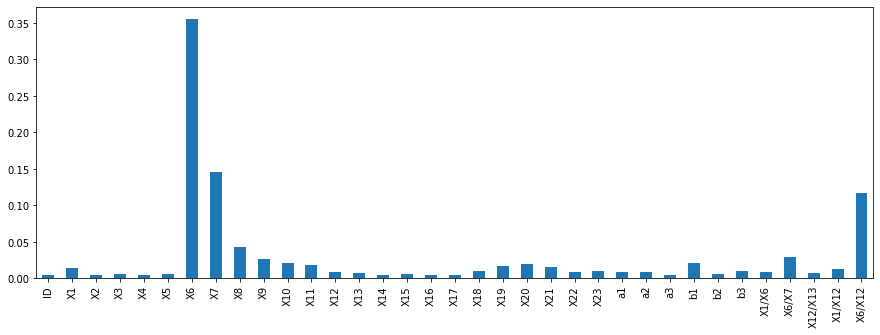

In [79]:
xgb_model = XGBClassifier()
print('XGB', cross_val_score(xgb_model, train_x, train_y, cv=10).mean())

xgb_model.fit(train_x, train_y)
fimp_df = pd.DataFrame({"fimp": xgb_model.feature_importances_}, index=train_x.columns)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
fimp_df.plot(ax=ax1, legend=False, kind='bar')
plt.show()

In [80]:
# Drop unnecessary element
train_x.drop(["ID", "a1", "b1", "b2", "a3", "b3"], axis=1, inplace=True)
train_x.drop(["X5", "X14"], axis=1, inplace=True)
df_test.drop(["ID", "a1", "b1", "b2", "a3", "b3"], axis=1, inplace=True)
df_test.drop(["X5", "X14"], axis=1, inplace=True)

XGB [0.80333333 0.80777778 0.8162963  0.80407407 0.82333333 0.8262963
 0.83222222 0.82777778 0.83111111 0.82555556]


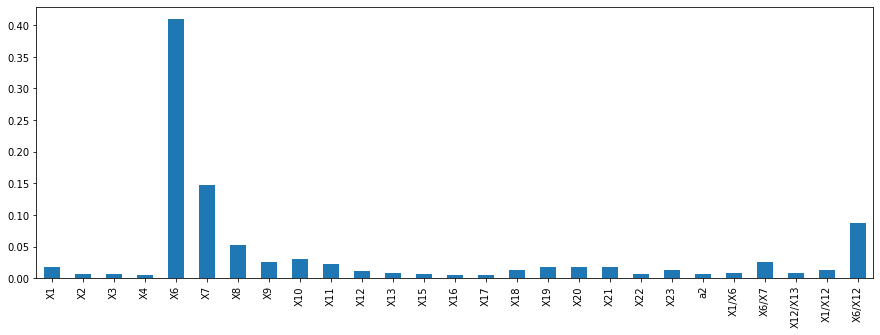

In [81]:
xgb_model = XGBClassifier()
print('XGB', cross_val_score(xgb_model, train_x, train_y, cv=10))

xgb_model.fit(train_x, train_y)
fimp_df = pd.DataFrame({"fimp": xgb_model.feature_importances_}, index=train_x.columns)

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,1,1)
fimp_df.plot(ax=ax1, legend=False, kind='bar')
plt.show()

In [82]:
from bayes_opt import BayesianOptimization

def xgb_function(eta, gamma, n_estimators, max_depth, min_child_weigh, subsample, colsample_bytree, alpha):
    xgb_model = XGBClassifier(eta=float(eta),
                              gamma=float(gamma),
                              n_estimators=int(n_estimators),
                              max_depth=int(max_depth),
                              min_child_weigh=int(min_child_weigh),
                              subsample=float(subsample),
                              colsample_bytree=float(colsample_bytree),
                              alpha=float(alpha),
                              random_state=0
                             )
    
    score = cross_val_score(xgb_model, train_x, train_y, scoring='accuracy', cv=10, n_jobs=-1).mean()
    return score
    
params = {'eta': (0.01, 1.0),
           'gamma': (0, 0.4),
           'n_estimators': (10, 200),
           'max_depth':(2, 10),
           'min_child_weigh': (1, 5),
           'subsample': (0.6, 1.0),
           'colsample_bytree': (0.6, 1.0),
           'alpha': (1e-5, 10)
          }

optimizer = BayesianOptimization(f=xgb_function, pbounds=params, verbose=2, random_state=0)
optimizer.maximize(init_points=5, n_iter=15, acq='ei')

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8187   |  5.488    |  0.8861   |  0.6067   |  0.218    |  5.389    |  3.584    |  93.14    |  0.9567   |
|  2        |  0.819    |  9.637    |  0.7534   |  0.7938   |  0.2116   |  6.544    |  4.702    |  23.5     |  0.6349   |
|  3        |  0.8148   |  0.2022   |  0.933    |  0.7804   |  0.348    |  9.829    |  4.197    |  97.68    |  0.9122   |
|  4        |  0.8192   |  1.183    |  0.856    |  0.1519   |  0.3779   |  6.175    |  2.659    |  60.27    |  0.9097   |
|  5        |  0.8169   |  4.562    |  0.8274   |  0.0286   |  0.2471   |  6.897    |  3.468    |  189.3    |  0.8727   |
|  6        |  0.8184   |  9.452    |  0.9679   |  0.6335   |  0.3411   |  2.232    |  2.796    |  10.36    |  0.8891   |
|  7        |  0.8188   

# Predict df_test

In [83]:
xgb_model = XGBClassifier(eta=float(optimizer.max['params']['eta']),
                    gamma=float(optimizer.max['params']['gamma']),
                    n_estimators=int(optimizer.max['params']['n_estimators']),
                    max_depth=int(optimizer.max['params']['max_depth']),
                    min_child_weigh=int(optimizer.max['params']['min_child_weigh']),
                    subsample=float(optimizer.max['params']['subsample']),
                    colsample_bytree=float(optimizer.max['params']['colsample_bytree']),
                    alpha=float(optimizer.max['params']['alpha']),
                    random_state=0
                   )

xgb_model.fit(train_x, train_y)
preds = xgb_model.predict(df_test)

# Probability of class 0 or 1
preds_proba = xgb_model.predict_proba(df_test)[:, 1]

df_ = pd.DataFrame()
df_["ID"] = df_test_raw["ID"]
df_y = []
for proba in tqdm(preds_proba):
    if proba >= 0.51:
        df_y.append(1)
    else:
        df_y.append(0)

df_['Y'] = df_y

100%|██████████| 3000/3000 [00:00<00:00, 325729.02it/s]


# KNN prediction for no data

In [84]:
# read & preprocess
df_train = pd.read_csv("train_data.csv")
df_test = pd.read_csv("test_data.csv")
nohist = "X12 == 0 and X13 == 0 and X14 == 0 and X15 == 0 and X16 == 0 and X17 == 0 and X18 == 0 and X19 == 0 and X20 == 0 and X21 == 0 and X22 == 0 and X23 == 0"
df_train_nohist = df_train.query(nohist)
df_test_nohist = df_test.query(nohist)

df_train_nohist

,id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
15,15,360000,2,1,1,49,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
16,16,180000,2,1,2,29,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
39,39,210000,1,1,2,29,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
73,73,240000,2,2,2,44,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
112,112,450000,1,1,1,40,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26913,26913,140000,1,1,2,29,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
26914,26914,360000,1,1,2,32,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0
26976,26976,230000,1,2,1,35,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,1
26982,26982,180000,1,1,1,32,-2,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# Pre-process KNN

def preprocess_knn(df_train, df_test):
    """historyがほぼない人用の前処理関数"""
    # preprocess
    cols = ["X1", "X4", "X5"]

    # z_scoreをするのでdfへconcatしないといけない
    df_train = df_train[cols]
    df_test = df_test[cols]
    df = pd.concat([df_train, df_test])

    len_df_train = len(df_train)
    len_df_test = len(df_test)
    len_df_all = len_df_train + len_df_test

    # min-max scaling +0.003!
    for col in cols:
        df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    # subsplit
    df_train = df.iloc[range(len_df_train), :]
    df_test = df.iloc[range(len_df_train, len_df_all), :]

    # return
    return df_train, df_test

df_train_nohist_pp, df_test_nohist_pp = preprocess_knn(df_train_nohist, df_test_nohist)
df_test_nohist_pp

,X1,X4,X5
107,0.500000,0.333333,0.358491
148,0.185714,0.666667,0.018868
161,0.014286,1.000000,0.245283
175,0.500000,0.666667,0.188679
257,0.214286,0.333333,0.075472
...,...,...,...
2809,0.500000,0.333333,0.132075
2814,0.328571,1.000000,0.132075
2834,0.185714,0.333333,0.226415
2910,0.500000,0.333333,0.396226


defaultdict(<class 'list'>, {1: [0.5983110543795577, 0.5899076930350199, 0.5856291883842145, 0.5898663262773464, 0.5787150303159238, 0.5828635251568982, 0.5940739164864258, 0.5786500254110082, 0.5674632722287227, 0.5968986750818471, 0.5982755971586947, 0.5969341323027102, 0.5589771773688379, 0.5955335720786205, 0.5407107990875675, 0.6207732037962864, 0.5898781453509674, 0.5758843621836921, 0.5772376461132976, 0.5926910848727677], 2: [0.6291824746776348, 0.6390277630039357, 0.6179543547376757, 0.6320249618834876, 0.6222092212412392, 0.6193430958881443, 0.6235506860972236, 0.6291942937512558, 0.6054024985521634, 0.6067616920185795, 0.6319895046626245, 0.6221914926308076, 0.6039014762022953, 0.6292356605089293, 0.6109870108380905, 0.6179484452008652, 0.6208145705539599, 0.6306421302698295, 0.6165360659031546, 0.6152123296576014], 3: [0.6081149759481851, 0.601088536680495, 0.6193608244985759, 0.5926497181150941, 0.5913437104799725, 0.5771903698188137, 0.6010826271436844, 0.5716058575328866

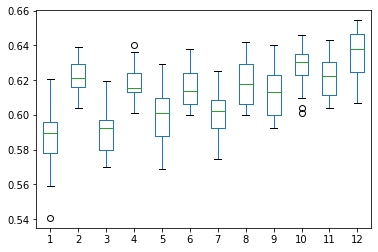

In [86]:
# knnの評価
train_x = df_train_nohist_pp.copy()
train_y = df_train_nohist["y"]

from collections import defaultdict

def validate_knn(train_x, train_y):
    d = defaultdict(list)
    for n_neighbors in range(1, 13):
        # sample数が少ないため,splitの方法によって多いに結果が変わる。
        # 20回試して箱ひげ図を作成
        for random_state in range(20):
            cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)
            accuracies = []
            for train_idx, test_idx in cv.split(train_x, train_y):
                trn_x = train_x.iloc[train_idx, :]
                val_x = train_x.iloc[test_idx, :]

                trn_y = train_y.iloc[train_idx]
                val_y = train_y.iloc[test_idx]

                clf = KNeighborsClassifier(n_neighbors=n_neighbors)
                clf.fit(trn_x, trn_y)

                pred_y = clf.predict(val_x)
                accuracies.append(accuracy_score(val_y, pred_y))
            d[n_neighbors].append(np.mean(accuracies))
    print(d)
    df = pd.DataFrame(d)
    df.plot(kind="box")
    
validate_knn(train_x, train_y)

In [90]:
# Data organization
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC

# df_label_zero
# df_train_zero
# df_label_non_zero
# df_train_non_zero
# df_test_zero
# df_test_non_zero

# XGB Classifier
xgb_model = XGBClassifier()
print('XGB', cross_val_score(xgb_model, train_x, train_y, cv=10).mean())

# NAIBE BAYES
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
print('Naive Bayes', cross_val_score(nb_model, train_x, train_y, cv=10).mean())

# KNN
knn = KNeighborsClassifier()
n_neighbors = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
param_grid = dict(n_neighbors=n_neighbors)
grid_search_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, n_jobs=-1, scoring='accuracy')
grid_search_knn.fit(train_x, train_y)
knn_best = grid_search_knn.best_estimator_
print('KNN Best Score', grid_search_knn.best_score_)
print('KNN Best Params', grid_search_knn.best_params_)

# SVM
svc = SVC()
params = {'kernel':['rbf'],'C':[1,10,100],'gamma':[0.05,0.0001,0.01,0.001]}
grid_search_svm = GridSearchCV(estimator=svc, param_grid=params, cv=10, n_jobs=-1, scoring='accuracy')
grid_search_svm.fit(train_x, train_y)
svm_best = grid_search_svm.best_estimator_
print('SVM Best Score', grid_search_svm.best_score_)
print('SVM Best Params', grid_search_svm.best_params_)

# Random Forest
rfc = RandomForestClassifier(random_state=99)
n_estimators = [10, 50, 100, 150, 200]
max_depth = [3, 4, 5, 6, 10, 20]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
grid_search_rfc =GridSearchCV(estimator=rfc, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search_rfc.fit(train_x, train_y)
rfc_best = grid_search_rfc.best_estimator_
print('Random Forest Best Score', grid_search_rfc.best_score_)
print('Random Forest Best Params', grid_search_rfc.best_params_)

XGB 0.6530712050078247
Naive Bayes 0.6320031298904538
KNN Best Score 0.6277973395931141
KNN Best Params {'n_neighbors': 8}
SVM Best Score 0.6362676056338028
SVM Best Params {'C': 100, 'gamma': 0.05, 'kernel': 'rbf'}
Random Forest Best Score 0.6685250391236307
Random Forest Best Params {'max_depth': 3, 'n_estimators': 200}


In [97]:
# Random best
def rfc_function(n_estimators, max_depth):
    rfc_model = RandomForestClassifier(n_estimators=int(n_estimators),
                              max_depth=int(max_depth),
                              random_state=0
                             )
    
    score = cross_val_score(rfc_model, train_x, train_y, scoring='accuracy', cv=10, n_jobs=-1).mean()
    return score

params = {'n_estimators': (10, 400),
           'max_depth':(2, 50),
          }
optimizer = BayesianOptimization(f=rfc_function, pbounds=params, verbose=2, random_state=0)
optimizer.maximize(init_points=20, n_iter=20, acq='ei')

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        |  0.6025   |  28.34    |  288.9    |
|  2        |  0.6011   |  30.93    |  222.5    |
|  3        |  0.6039   |  22.34    |  261.9    |
|  4        |  0.5955   |  23.0     |  357.8    |
|  5        |  0.5954   |  48.26    |  159.5    |
|  6        |  0.6025   |  40.0     |  216.3    |
|  7        |  0.5969   |  29.27    |  371.0    |
|  8        |  0.6755   |  5.41     |  43.98    |
|  9        |  0.6418   |  2.97     |  334.7    |
|  10       |  0.5955   |  39.35    |  349.3    |
|  11       |  0.6053   |  48.97    |  321.7    |
|  12       |  0.6011   |  24.15    |  314.4    |
|  13       |  0.6517   |  7.677    |  259.6    |
|  14       |  0.6475   |  8.881    |  378.4    |
|  15       |  0.6011   |  27.05    |  171.7    |
|  16       |  0.6137   |  14.7     |  312.0    |
|  17       |  0.6067   |  23.9     |  231.7    |
|  18       |  0.6404   |  2.902    |  250.9    |


In [91]:
# 結局testdataも絨毯爆撃したが,n=4が最もよいという結果に。
def predict_test_by_knn(train_x, train_y, test_x, n_neighbors):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(train_x, train_y)
    pred_y = clf.predict(test_x)
    return pred_y

n_neighbors = 12
pred_y = predict_test_by_knn(train_x, train_y, df_test_nohist_pp, n_neighbors)

# 今回
df_.loc[df_test_nohist["ID"], "Y"] = pred_y

df_.to_csv("result.xgb&knn.{}.csv".format(n_neighbors), index=False)

In [100]:
# Random Forestも
rfc_best = RandomForestClassifier(n_estimators=int(optimizer.max['params']['n_estimators']),
                    max_depth=int(optimizer.max['params']['max_depth']),
                    random_state=0
                   )
rfc_best.fit(train_x, train_y)
pred_y = rfc_best.predict(df_test_nohist_pp)

# 今回
df_.loc[df_test_nohist["ID"], "Y"] = pred_y

df_.to_csv("result.xgb&rfc.csv", index=False)